In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import motiflets.motiflets as mtfls
import motiflets.plotting as mtfls_plt
from tests.audio.lyrics import *
import motiflets_uni.motiflets as mtfls_uni
from motiflets_uni.plotting import Motiflets as Motiflets_uni
from sklearn.decomposition import PCA
import tests.amc.amc_parser as amc_parser

/home/niyaz/Programme/miniconda3/envs/ubuntu-motiflets-mv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
k_max = 6
motif_length = 120
n_dims_rest = 18
n_dims_rest2 = 12

def get_joint_pos_dict(c_joints, c_motion):
    c_joints['root'].set_motion(c_motion)
    out_dict = {}
    for k1, v1 in c_joints['root'].to_dict().items():
        for k2, v2 in zip('xyz', v1.coordinate[:, 0]):
            out_dict['{}_{}'.format(k1, k2)] = v2
    return out_dict


def exclude_body_joints(df):
    # Filter body joints as suggested by Yeh
    exclude = ['root', 'lowerback', 'upperback',
               'thorax', 'lowerneck', 'upperneck', 'head']
    exclude_bones = []
    exclude_bones.extend([x + "_" + k for x in exclude for k in 'xyz'])
    exclude_bones

    return df[~df.index.isin(exclude_bones)]


def include_joints(df, include, add_xyz=True):
    include_bones = []

    if add_xyz:
        include_bones.extend([x + "_" + k for x in include for k in 'xyz'])
    else:
        include_bones = include

    return df[df.index.isin(include_bones)]

amc_name = "93_08" 
asf_path = 'datasets/motion_data/93.asf'
amc_path = 'datasets/motion_data/' + amc_name + '.amc'

joints_to_use = ['rclavicle', 'rhumerus', 'rradius', 'rwrist',
             'rhand', 'rfingers', 'rthumb',
             'rfemur', 'rtibia', 'rfoot', 'rtoes']
add_xyz=True

joints = amc_parser.parse_asf(asf_path)
motions = amc_parser.parse_amc(amc_path)

df = pd.DataFrame([get_joint_pos_dict(joints, c_motion) for c_motion in motions]).T
df = exclude_body_joints(df)
df = include_joints(df, joints_to_use, add_xyz=add_xyz)

print("Used joints:", joints_to_use)
series = df.values
print(f'DatensatzLänge: {series.shape[1]}')
print(series.shape)


Used joints: ['rclavicle', 'rhumerus', 'rradius', 'rwrist', 'rhand', 'rfingers', 'rthumb', 'rfemur', 'rtibia', 'rfoot', 'rtoes']
DatensatzLänge: 557
(33, 557)


In [3]:
ml_full = Motiflets(amc_name, df,
                dimension_labels=df.index
                )

dists_full, motiflets_full, motiflets_dims_full, elbow_points_full = ml_full.fit_k_elbow(
    k_max,
    plot_elbows=False,
    plot_motifs_as_grid=False,
    motif_length=motif_length)

Data (33, 557)


Chosen window-size: 120 in 0.5 s
Elbow Points [3]


In [4]:
ml_rest = Motiflets(amc_name, df,
                dimension_labels=df.index,
                n_dims=n_dims_rest
                )

dists_rest, motiflets_rest, motiflets_dims_rest, elbow_points_rest = ml_rest.fit_k_elbow(
    k_max,
    plot_elbows=False,
    plot_motifs_as_grid=False,
    motif_length=motif_length)

Data (33, 557)


Compute ks (6):   0%|          | 0/5 [00:00<?, ?it/s]

Chosen window-size: 120 in 0.2 s
Elbow Points [3]


In [5]:
ml_rest2 = Motiflets(amc_name, df,
                dimension_labels=df.index,
                n_dims=n_dims_rest2
                )

dists_rest2, motiflets_rest2, motiflets_dims_rest2, elbow_points_rest2 = ml_rest2.fit_k_elbow(
                k_max,
                plot_elbows=False,
                plot_motifs_as_grid=False,
                motif_length=motif_length)

Data (33, 557)


Chosen window-size: 120 in 0.1 s
Elbow Points [4]


In [6]:
pca = PCA(n_components=1)
np_pca = pca.fit_transform(df.T)
series_pca = pd.Series(np_pca.flatten(), index=df.T.index, name='Charleston Motion Capture PCA')

ml_uni = Motiflets_uni(amc_name, series_pca)
dists_uni, motiflets_uni, elbow_points_uni =  ml_uni.fit_k_elbow(
    k_max,
    plot_elbows=False,
    plot_motifs_as_grid=False,
    motif_length=motif_length)

Data 557


Chosen window-size: 120 in 0.2 s
Elbow Points [4]


In [7]:
_ , df_gt = mtfls.read_dataset_with_index("vanilla_ice.csv", "charleston.csv", sampling_factor=20000)
print(df_gt.shape)
my_gt = df_gt["footwork"][0]
print(my_gt)
gt_motiflets = np.array([m[0] for m in my_gt])
print(gt_motiflets)

Dataset Original Length n:  23095
Dataset Sampled Length n:  23095
(1, 1)
[[20, 140], [158, 278], [296, 416]]
[ 20 158 296]


/home/niyaz/Bibliothek/GitHub/Bachlorarbeit/Code/motiflets-mv_tests/motiflets/motiflets.py:100: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv(full_path, index_col=0, squeeze=True)


In [8]:
#Ground Truth extent
_, raw_data_for_gt = mtfls.pd_series_to_numpy(df)
D_full_gt, knns_gt = mtfls.compute_distance_matrix(
    raw_data_for_gt, motif_length, k_max,
    slack=0.5,
    sum_dims=False)

gt_dims = [x for x in range(df.shape[0])]
gt_motiflets_np = np.array(gt_motiflets)
#gt_extent = mtfls.get_pairwise_extent(D_full_gt, gt_motiflets_np, gt_dims)

upperbound_gt=np.inf
gt_extent = np.float64(0.0)
for ii in range(len(gt_motiflets_np) - 1):
    i = gt_motiflets_np[ii]

    for jj in range(ii + 1, len(gt_motiflets_np)):
        j = gt_motiflets_np[jj]
        gt_extent = max(gt_extent, D_full_gt[gt_dims, i, j].mean())
        if gt_extent > upperbound_gt:
            gt_extent =  np.inf

print(gt_extent)

87.53674


(5, 1)
Index(['Ground Truth', 'Unrestricted: m=33, k=3', 'Restricted: m=18, k=3',
       'Restricted: m=12, k=4', 'PCA, k=4'],
      dtype='object')


/home/niyaz/Bibliothek/GitHub/Bachlorarbeit/Code/motiflets-mv_tests/motiflets/plotting.py:1825: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["_dim_" + str(dim) + "_" + str(aa)] = normed_data
/home/niyaz/Bibliothek/GitHub/Bachlorarbeit/Code/motiflets-mv_tests/motiflets/plotting.py:1825: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["_dim_" + str(dim) + "_" + str(aa)] = normed_data
/home/niyaz/Bibliothek/GitHub/Bachlorarbeit/Code/motiflets-mv_tests/motiflets/plotting.py:1825: PerformanceWarning: DataFrame is highly fragment

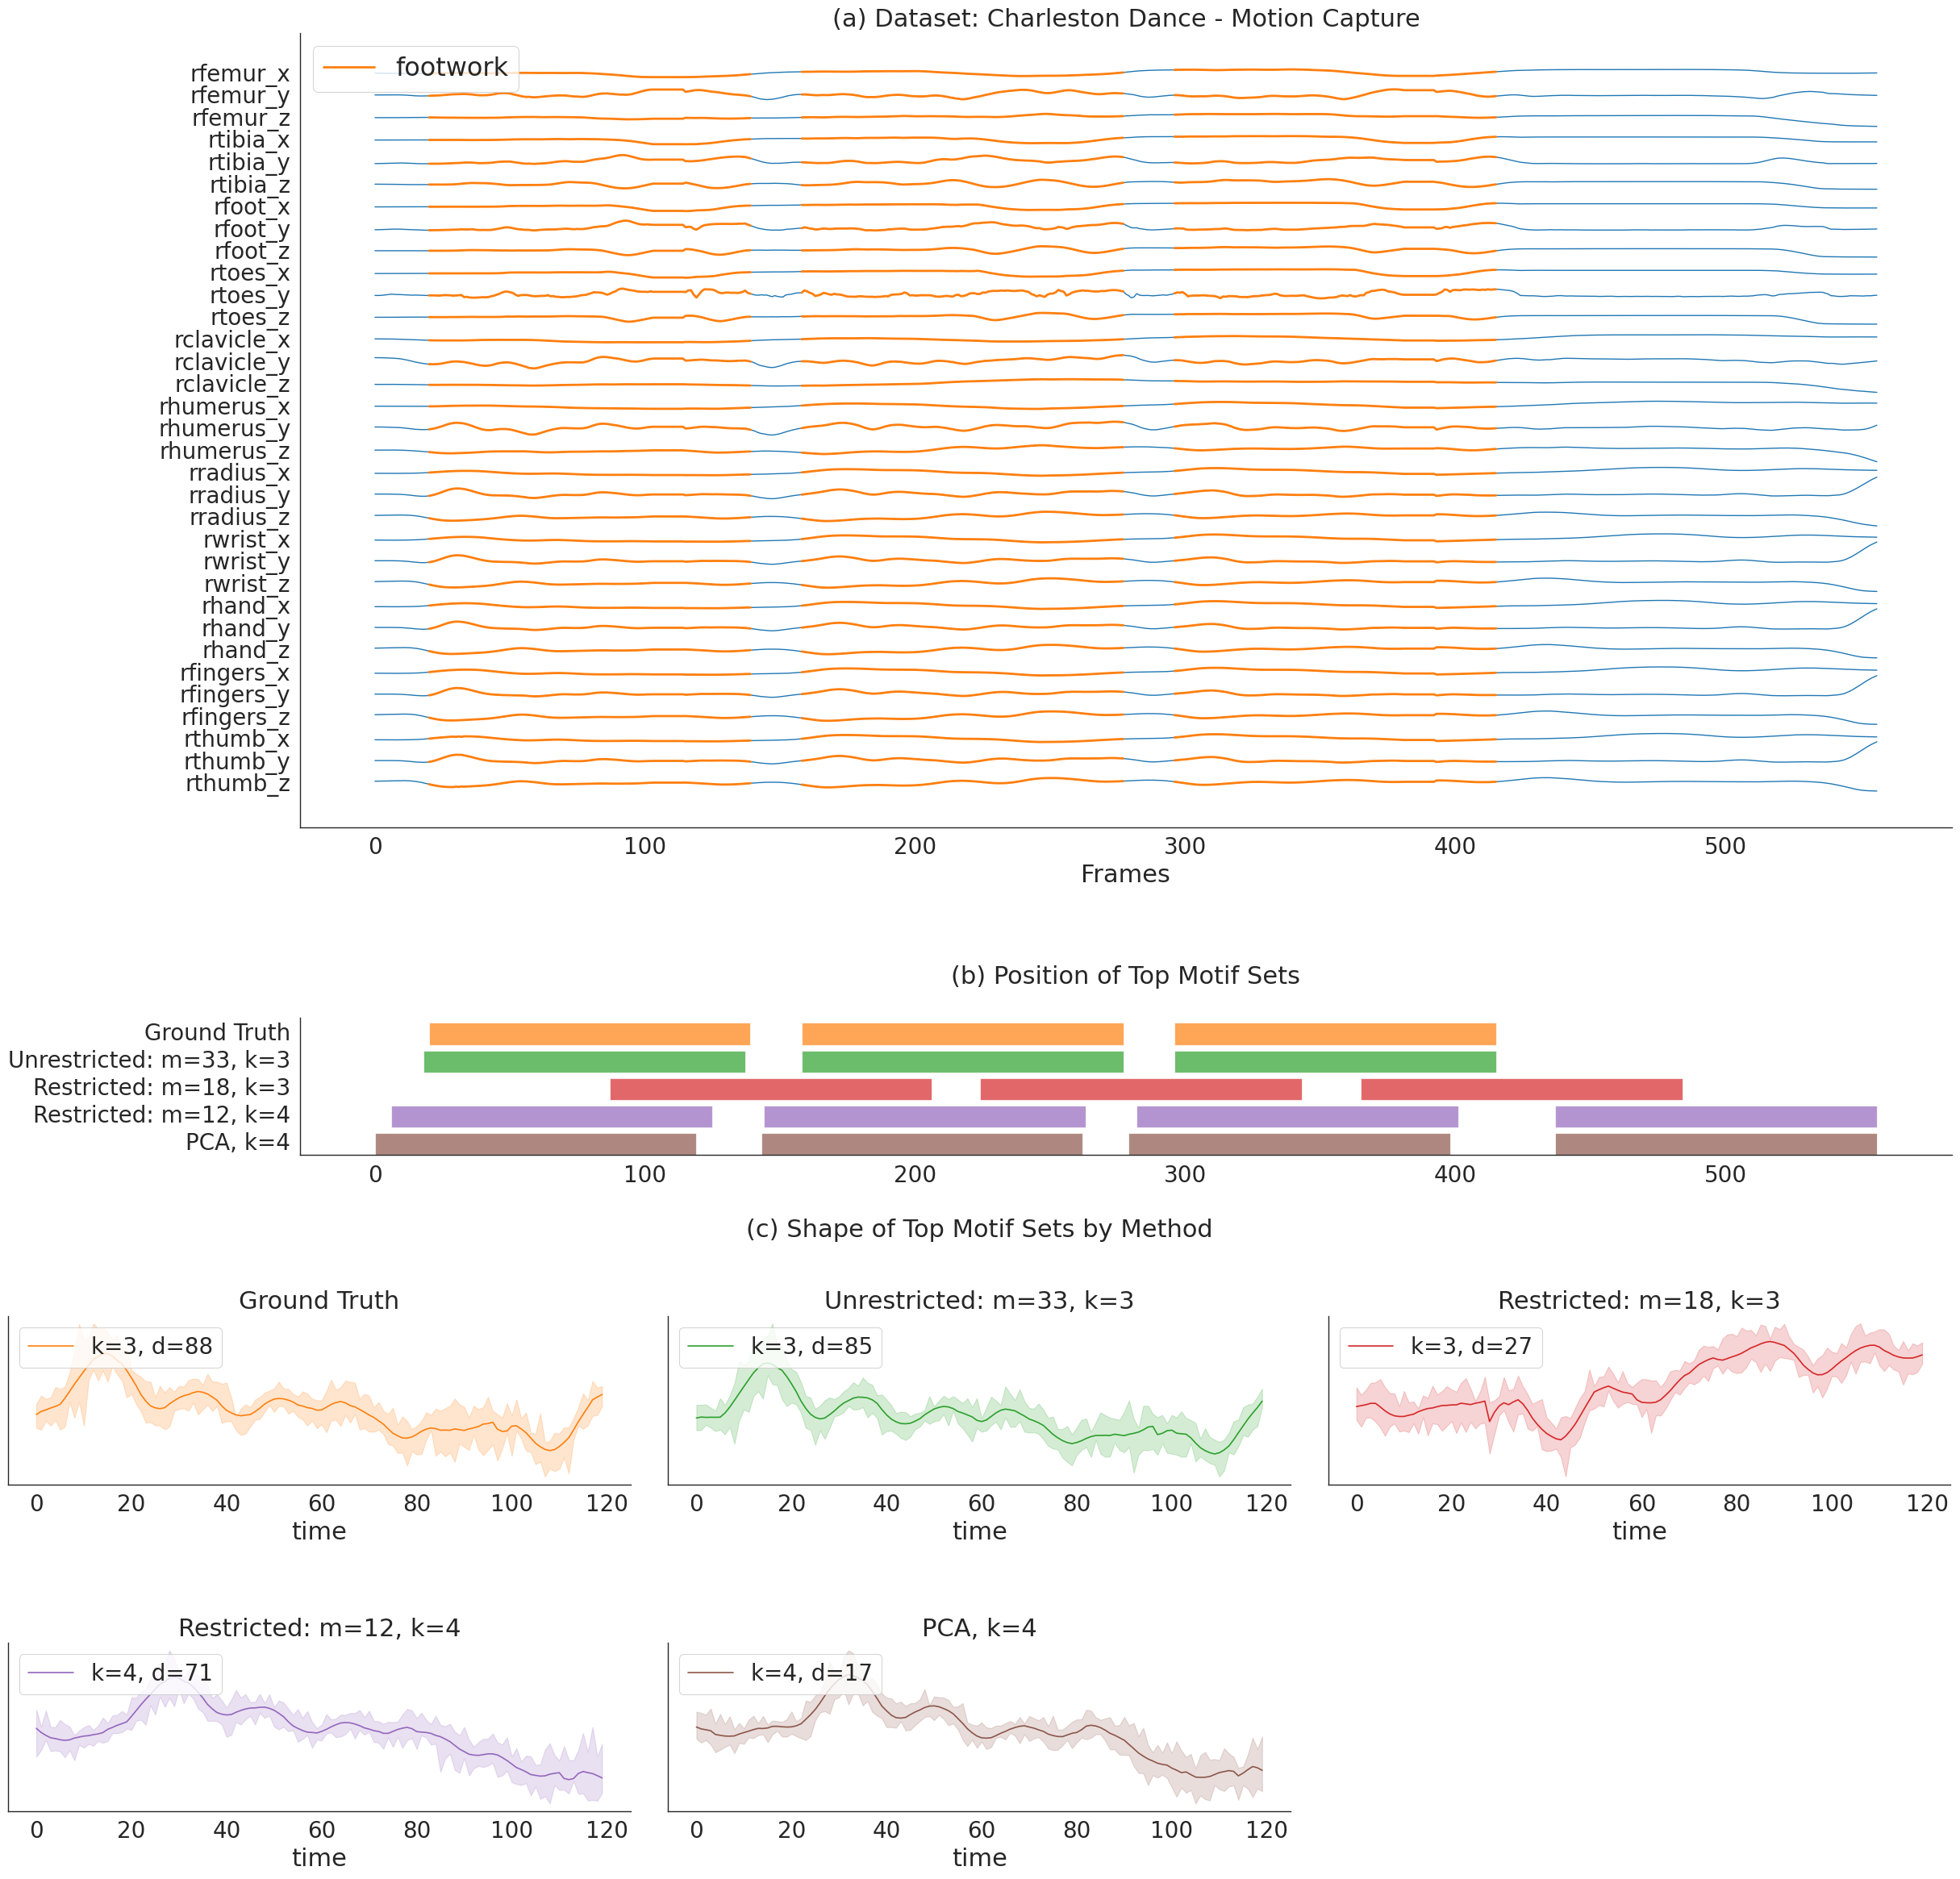

In [10]:
ds_name = "Charleston Dance - Motion Capture"


df_cmp = pd.DataFrame()
dists_cmp = []
dims_cmp = []
minature_labels = []

df_cmp[f'Ground Truth'] = [gt_motiflets.tolist()]
dists_cmp.append(0)
dims_cmp.append([0])
minature_labels.append(f'k={len(gt_motiflets)}, d={round(gt_extent)}')


for elbow in elbow_points_full:
    df_cmp[f'Unrestricted: m={df.shape[0]}, k={elbow}'] = [motiflets_full[elbow].tolist()]
    dists_cmp.append(dists_full[elbow])
    dims_cmp.append(motiflets_dims_full[elbow])
    minature_labels.append(f'k={elbow}, d={round(dists_full[elbow])}')

for elbow in elbow_points_rest:
    df_cmp[f'Restricted: m={n_dims_rest}, k={elbow}'] = [motiflets_rest[elbow].tolist()]
    dists_cmp.append(dists_rest[elbow])
    dims_cmp.append(motiflets_dims_rest[elbow])
    minature_labels.append(f'k={elbow}, d={round(dists_rest[elbow])}')

for elbow in elbow_points_rest2:
    df_cmp[f'Restricted: m={n_dims_rest2}, k={elbow}'] = [motiflets_rest2[elbow].tolist()]
    dists_cmp.append(dists_rest2[elbow])
    dims_cmp.append(motiflets_dims_rest2[elbow])
    minature_labels.append(f'k={elbow}, d={round(dists_rest2[elbow])}')

for elbow in elbow_points_uni:
    df_cmp[f'PCA, k={elbow}'] = [motiflets_uni[elbow].tolist()]
    dists_cmp.append(dists_uni[elbow])
    dims_cmp.append(motiflets_dims_full[elbow]) # Use all dimensions
    minature_labels.append(f'k={elbow}, d={round(dists_uni[elbow])}')
#df_cmp[f'Unrestricted'] = [motiflets_uni[20].tolist()]

df_cmp = df_cmp.T
df_cmp.columns = ["offsets"]
print(df_cmp.shape)

elbow_points = [x for x in range(0, df_cmp.shape[0])]

#mtfls_plt.plot_competitors(df, ds_name, df_cmp.offsets.values, motif_length=180)

print(df_cmp.index)

mtfls_plt.plot_grid_motiflets_niyaz(
    ds_name, df, df_cmp.offsets.values, elbow_points,
    dists_cmp, motif_length,
    dimension_labels=df.index,
    method_names=df_cmp.index,
    ground_truth=gt_motiflets,
    ts_label=f'footwork',
    x_label="Frames",
    minature_labels=minature_labels,
    font_size=30,
    save_path="../../Latex/BachelorarbeitFinal/Images/qual/charleston.pdf"
    )
